<a href="https://colab.research.google.com/github/leoclementliao/colab-yolov3/blob/master/yolov3_s1_data_preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!/opt/bin/nvidia-smi

/bin/bash: /opt/bin/nvidia-smi: No such file or directory


In [2]:
## git yolo3_tf2 and pip libraries
!git clone https://github.com/zzh8829/yolov3-tf2
%cd yolov3-tf2/
!pip install -r requirements-gpu.txt


Cloning into 'yolov3-tf2'...
remote: Enumerating objects: 341, done.
remote: Total 341 (delta 0), reused 0 (delta 0), pack-reused 341
Receiving objects: 100% (341/341), 4.16 MiB | 27.67 MiB/s, done.
Resolving deltas: 100% (198/198), done.
/content/yolov3-tf2
Obtaining file:///content/yolov3-tf2 (from -r requirements-gpu.txt (line 6))
     |████████████████████████████████| 421.8MB 37kB/s 
     |████████████████████████████████| 28.7MB 176kB/s 
     |████████████████████████████████| 3.9MB 37.1MB/s 
     |████████████████████████████████| 450kB 41.2MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=f4a4cda80de9641be5e3b71dad7cd33d83d11af6b8c1b4cc9219ecabcc21c435
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.2.0rc2 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.2.0rc2 has requirement tensorboard<2.

In [3]:
## Download new dataset
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2009/VOCtrainval_11-May-2009.tar -O ./data/voc2009_raw.tar
!mkdir -p ./data/voc2009_raw
!tar -xf ./data/voc2009_raw.tar -C ./data/voc2009_raw

--2020-04-13 09:51:10--  http://host.robots.ox.ac.uk/pascal/VOC/voc2009/VOCtrainval_11-May-2009.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 935534080 (892M) [application/x-tar]
Saving to: ‘./data/voc2009_raw.tar’

./data/voc2009_raw. 100%[===================>] 892.19M  8.98MB/s    in 1m 40s  

2020-04-13 09:52:51 (8.89 MB/s) - ‘./data/voc2009_raw.tar’ saved [935534080/935534080]



In [0]:
import time
import os
import hashlib

from absl import app, flags, logging
from absl.flags import FLAGS
import tensorflow as tf
import lxml.etree
import tqdm
import cv2


In [24]:
!ls ./data/voc2009_raw/VOCdevkit/

VOC2009


In [0]:
## Definie variables
# flags.DEFINE_string('data_dir', './data/voc2012_raw/VOCdevkit/VOC2012/',
#                     'path to raw PASCAL VOC dataset')
# flags.DEFINE_enum('split', 'train', [
#                   'train', 'val'], 'specify train or val spit')
# flags.DEFINE_string('output_file', './data/voc2012_train.tfrecord', 'outpot dataset')
# flags.DEFINE_string('classes', './data/voc2012.names', 'classes file')


dataset_name = 'train'
data_dir = '/content/yolov3-tf2/data/voc2009_raw/VOCdevkit/VOC2009'
output_file = f'/content/yolov3-tf2/data/voc2009_{dataset_name}.tfrecord'
classes_dir = '/content/yolov3-tf2/data/voc2012.names'

In [0]:
def build_example(annotation, class_map):
    img_path = os.path.join(data_dir, 'JPEGImages', annotation['filename'])
    img_raw = open(img_path, 'rb').read()
    key = hashlib.sha256(img_raw).hexdigest()

    width = int(annotation['size']['width'])
    height = int(annotation['size']['height'])

    xmin = []
    ymin = []
    xmax = []
    ymax = []
    classes = []
    classes_text = []
    truncated = []
    views = []
    difficult_obj = []
    if 'object' in annotation:
        for obj in annotation['object']:
            difficult = bool(int(obj['difficult']))
            difficult_obj.append(int(difficult))

            xmin.append(float(obj['bndbox']['xmin']) / width)
            ymin.append(float(obj['bndbox']['ymin']) / height)
            xmax.append(float(obj['bndbox']['xmax']) / width)
            ymax.append(float(obj['bndbox']['ymax']) / height)
            classes_text.append(obj['name'].encode('utf8'))
            classes.append(class_map[obj['name']])
            truncated.append(int(obj['truncated']))
            views.append(obj['pose'].encode('utf8'))

    example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'image/width': tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'image/filename': tf.train.Feature(bytes_list=tf.train.BytesList(value=[
            annotation['filename'].encode('utf8')])),
        'image/source_id': tf.train.Feature(bytes_list=tf.train.BytesList(value=[
            annotation['filename'].encode('utf8')])),
        'image/key/sha256': tf.train.Feature(bytes_list=tf.train.BytesList(value=[key.encode('utf8')])),
        'image/encoded': tf.train.Feature(bytes_list=tf.train.BytesList(value=[img_raw])),
        'image/format': tf.train.Feature(bytes_list=tf.train.BytesList(value=['jpeg'.encode('utf8')])),
        'image/object/bbox/xmin': tf.train.Feature(float_list=tf.train.FloatList(value=xmin)),
        'image/object/bbox/xmax': tf.train.Feature(float_list=tf.train.FloatList(value=xmax)),
        'image/object/bbox/ymin': tf.train.Feature(float_list=tf.train.FloatList(value=ymin)),
        'image/object/bbox/ymax': tf.train.Feature(float_list=tf.train.FloatList(value=ymax)),
        'image/object/class/text': tf.train.Feature(bytes_list=tf.train.BytesList(value=classes_text)),
        'image/object/class/label': tf.train.Feature(int64_list=tf.train.Int64List(value=classes)),
        'image/object/difficult': tf.train.Feature(int64_list=tf.train.Int64List(value=difficult_obj)),
        'image/object/truncated': tf.train.Feature(int64_list=tf.train.Int64List(value=truncated)),
        'image/object/view': tf.train.Feature(bytes_list=tf.train.BytesList(value=views)),
    }))
    return example


def parse_xml(xml):
    if not len(xml):
        return {xml.tag: xml.text}
    result = {}
    for child in xml:
        child_result = parse_xml(child)
        if child.tag != 'object':
            result[child.tag] = child_result[child.tag]
        else:
            if child.tag not in result:
                result[child.tag] = []
            result[child.tag].append(child_result[child.tag])
    return {xml.tag: result}

In [41]:
class_map = {name: idx for idx, name in enumerate(
    open(classes_dir).read().splitlines())}

logging.info("Class mapping loaded: %s", class_map)

writer = tf.io.TFRecordWriter(output_file)
image_list = open(os.path.join(
    data_dir, 'ImageSets', 'Main', 'aeroplane_%s.txt' % dataset_name)).read().splitlines()
logging.info("Image list loaded: %d", len(image_list))
for image in tqdm.tqdm(image_list):
    name, _ = image.split()
    annotation_xml = os.path.join(
        data_dir, 'Annotations', name + '.xml')
    annotation_xml = lxml.etree.fromstring(open(annotation_xml).read())
    annotation = parse_xml(annotation_xml)['annotation']
    tf_example = build_example(annotation, class_map)
    writer.write(tf_example.SerializeToString())
writer.close()

100%|██████████| 3473/3473 [00:04<00:00, 867.74it/s]


In [0]:
tf_example

In [0]:
from yolov3_tf2.dataset import load_tfrecord_dataset, transform_images
from yolov3_tf2.utils import draw_outputs

In [0]:
IMAGE_FEATURE_MAP = {
    # 'image/width': tf.io.FixedLenFeature([], tf.int64),
    # 'image/height': tf.io.FixedLenFeature([], tf.int64),
    # 'image/filename': tf.io.FixedLenFeature([], tf.string),
    # 'image/source_id': tf.io.FixedLenFeature([], tf.string),
    # 'image/key/sha256': tf.io.FixedLenFeature([], tf.string),
    'image/encoded': tf.io.FixedLenFeature([], tf.string),
    # 'image/format': tf.io.FixedLenFeature([], tf.string),
    'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
    'image/object/class/text': tf.io.VarLenFeature(tf.string),
    # 'image/object/class/label': tf.io.VarLenFeature(tf.int64),
    # 'image/object/difficult': tf.io.VarLenFeature(tf.int64),
    # 'image/object/truncated': tf.io.VarLenFeature(tf.int64),
    # 'image/object/view': tf.io.VarLenFeature(tf.string),
}
def parse_tfrecord(tfrecord, class_table, size):
    x = tf.io.parse_single_example(tfrecord, IMAGE_FEATURE_MAP)
    x_train = tf.image.decode_jpeg(x['image/encoded'], channels=3)
    x_train = tf.image.resize(x_train, (size, size))

    class_text = tf.sparse.to_dense(
        x['image/object/class/text'], default_value='')
    labels = tf.cast(class_table.lookup(class_text), tf.float32)
    y_train = tf.stack([tf.sparse.to_dense(x['image/object/bbox/xmin']),
                        tf.sparse.to_dense(x['image/object/bbox/ymin']),
                        tf.sparse.to_dense(x['image/object/bbox/xmax']),
                        tf.sparse.to_dense(x['image/object/bbox/ymax']),
                        labels], axis=1)

    paddings = [[0, FLAGS.yolo_max_boxes - tf.shape(y_train)[0]], [0, 0]]
    y_train = tf.pad(y_train, paddings)

    return x_train, y_train


def load_tfrecord_dataset(file_pattern, class_file, size=416):
    LINE_NUMBER = -1  # TODO: use tf.lookup.TextFileIndex.LINE_NUMBER
    class_table = tf.lookup.StaticHashTable(tf.lookup.TextFileInitializer(
        class_file, tf.string, 0, tf.int64, LINE_NUMBER, delimiter="\n"), -1)

    files = tf.data.Dataset.list_files(file_pattern)
    dataset = files.flat_map(tf.data.TFRecordDataset)
    return dataset.map(lambda x: parse_tfrecord(x, class_table, size))

In [67]:
files = tf.data.Dataset.list_files(output_file)
dataset = files.flat_map(tf.data.TFRecordDataset)
dataset

<FlatMapDataset shapes: (), types: tf.string>

In [63]:
output_file


'/content/yolov3-tf2/data/voc2009_train.tfrecord'

In [68]:
dataset = load_tfrecord_dataset('/content/yolov3-tf2/data/voc_train.tfrecord', classes_dir, size=416)
dataset = dataset.shuffle(512)



AttributeError: ignored

In [0]:
class_names = [c.strip() for c in open(FLAGS.classes).readlines()]
logging.info('classes loaded')

dataset = load_tfrecord_dataset(FLAGS.dataset, FLAGS.classes, FLAGS.size)
dataset = dataset.shuffle(512)

for image, labels in dataset.take(1):
    boxes = []
    scores = []
    classes = []
    for x1, y1, x2, y2, label in labels:
        if x1 == 0 and x2 == 0:
            continue

        boxes.append((x1, y1, x2, y2))
        scores.append(1)
        classes.append(label)
    nums = [len(boxes)]
    boxes = [boxes]
    scores = [scores]
    classes = [classes]

    logging.info('labels:')
    for i in range(nums[0]):
        logging.info('\t{}, {}, {}'.format(class_names[int(classes[0][i])],
                                            np.array(scores[0][i]),
                                            np.array(boxes[0][i])))

    img = cv2.cvtColor(image.numpy(), cv2.COLOR_RGB2BGR)
    img = draw_outputs(img, (boxes, scores, classes, nums), class_names)
    cv2.imwrite(FLAGS.output, img)
    logging.info('output saved to: {}'.format(FLAGS.output))

In [8]:
!python tools/visualize_dataset.py --dataset ./data/voc_train.tfrecord --classes=./data/voc2012.names

2020-04-13 10:00:53.311537: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2020-04-13 10:00:53.311671: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2020-04-13 10:00:53.311701: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
I0413 10:00:54.366546 140190669993856 visualize_dataset.py:22] classes loaded
2020-04-13 10:00:54.369692: E tensorflow/stream_executor/cuda/cuda_driver.c

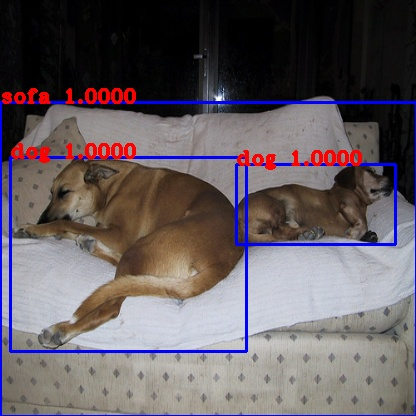

In [9]:
from IPython.display import Image
Image(filename='./output.jpg')